# Comparación de operaciones. Pyspark

In [0]:
from pyspark.sql import SparkSession

#spark=SparkSession.builder.master("local[1]").appName("pyspark_comparation").config("spark.some.config.option", "some-value").getOrCreate()

In [0]:
import time
import datetime
#from IPython.display import display

In [0]:
spark=SparkSession.builder.appName("pyspark_comparation").config("spark.some.config.option", "some-value").getOrCreate()

In [0]:
prev = datetime.datetime.now()
# File location and type
file_location = "/FileStore/tables/Course_info.csv" #"/Users/daniela.almendarez/Desktop/Proyecto_comparacion/Course_info.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
info = spark.read.options(escape='"', header = 'True').option("multiline",'true').csv(file_location)
#info = spark.read.format(file_type).option("inferSchema", infer_schema).option("header", first_row_is_header)\
#.option("sep", delimiter).load(file_location)
info.show(5)
#display(info)
print(datetime.datetime.now() - prev)

+------+--------------------+-------+------+--------------------+---------------+----------+-----------+------------+------------+------------------+--------------------+----------------+---------+-------------------+-------------+--------+--------------------+---------------+------------------+
|    id|               title|is_paid| price|            headline|num_subscribers|avg_rating|num_reviews|num_comments|num_lectures|content_length_min|      published_time|last_update_date| category|        subcategory|        topic|language|          course_url|instructor_name|    instructor_url|
+------+--------------------+-------+------+--------------------+---------------+----------+-----------+------------+------------+------------------+--------------------+----------------+---------+-------------------+-------------+--------+--------------------+---------------+------------------+
|4715.0|Online Vegan Vege...|   True| 24.99|Learn to cook del...|         2231.0|      3.75|      134.0|     

In [0]:
info.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- is_paid: string (nullable = true)
 |-- price: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- num_subscribers: string (nullable = true)
 |-- avg_rating: string (nullable = true)
 |-- num_reviews: string (nullable = true)
 |-- num_comments: string (nullable = true)
 |-- num_lectures: string (nullable = true)
 |-- content_length_min: string (nullable = true)
 |-- published_time: string (nullable = true)
 |-- last_update_date: string (nullable = true)
 |-- category: string (nullable = true)
 |-- subcategory: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- language: string (nullable = true)
 |-- course_url: string (nullable = true)
 |-- instructor_name: string (nullable = true)
 |-- instructor_url: string (nullable = true)



In [0]:
prev = datetime.datetime.now()
info=info.withColumn('num_subscribers',info.num_subscribers.cast('int'))
info=info.withColumn('num_reviews',info.num_reviews.cast('int'))
info=info.withColumn('num_comments',info.num_comments.cast('int'))
info=info.withColumn('num_lectures',info.num_lectures.cast('int'))
info=info.withColumn('published_time',info.published_time.cast('timestamp'))
info=info.withColumn('last_update_date',info.last_update_date.cast('date'))
info.printSchema()
print(datetime.datetime.now() - prev)

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- is_paid: string (nullable = true)
 |-- price: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- num_subscribers: integer (nullable = true)
 |-- avg_rating: string (nullable = true)
 |-- num_reviews: integer (nullable = true)
 |-- num_comments: integer (nullable = true)
 |-- num_lectures: integer (nullable = true)
 |-- content_length_min: string (nullable = true)
 |-- published_time: timestamp (nullable = true)
 |-- last_update_date: date (nullable = true)
 |-- category: string (nullable = true)
 |-- subcategory: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- language: string (nullable = true)
 |-- course_url: string (nullable = true)
 |-- instructor_name: string (nullable = true)
 |-- instructor_url: string (nullable = true)

0:00:00.088754


In [0]:
import pyspark.sql.functions as F
from pyspark.sql.types import StringType

### Creación de una nueva columna con los nombres de usuario, usando regex para extraerlos de los url dados

In [0]:
prev = datetime.datetime.now()
info = info.withColumn("instructor_username", F.regexp_extract(info.instructor_url, '/[A-Za-z]+/(\S*)/|(\s)',1))
info = info.withColumn("course_name", F.regexp_extract(info.course_url, '/[A-Za-z]+/(\S*)/|(\s)',1))
info.show()
print(datetime.datetime.now() - prev)

+------+--------------------+-------+------+--------------------+---------------+----------+-----------+------------+------------+------------------+-------------------+----------------+--------------------+--------------------+---------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    id|               title|is_paid| price|            headline|num_subscribers|avg_rating|num_reviews|num_comments|num_lectures|content_length_min|     published_time|last_update_date|            category|         subcategory|          topic|language|          course_url|     instructor_name|      instructor_url| instructor_username|         course_name|
+------+--------------------+-------+------+--------------------+---------------+----------+-----------+------------+------------+------------------+-------------------+----------------+--------------------+--------------------+---------------+--------+--------------------+--------

### Muestra el curso más antiguo y el más reciente con su fecha de publicación

In [0]:
prev = datetime.datetime.now()
old_date=F.min('published_time').alias('Primer_curso')
recent_date=F.max('published_time').alias('Ultimo_curso')
dates=info.select(old_date,recent_date).collect()
info.select(info.published_time,info.last_update_date,info.title).filter(info.published_time.isin([dates[0][0],dates[0][1]])).show()
print(datetime.datetime.now() - prev)

+-------------------+----------------+--------------------+
|     published_time|last_update_date|               title|
+-------------------+----------------+--------------------+
|2010-01-12 18:09:46|            null|The Lean Startup ...|
|2022-10-05 17:04:08|      2022-10-03|Manual para la Pe...|
+-------------------+----------------+--------------------+

0:00:04.991220


### Cuenta el número de cursos por lenguaje

In [0]:
prev = datetime.datetime.now()
courses_per_language=info.groupBy(info.language).count()
courses_per_language=courses_per_language.sort(F.col('count').desc())
courses_per_language.show(courses_per_language.count(),False)
print(datetime.datetime.now() - prev)

+-------------------+------+
|language           |count |
+-------------------+------+
|English            |123921|
|Portuguese         |18471 |
|Spanish            |17428 |
|Turkish            |8100  |
|Japanese           |7006  |
|German             |6101  |
|French             |5465  |
|Arabic             |5197  |
|Italian            |3637  |
|Russian            |2686  |
|Hindi              |1758  |
|Korean             |1660  |
|Indonesian         |1580  |
|Polish             |1530  |
|Traditional Chinese|1014  |
|Simplified Chinese |995   |
|Urdu               |530   |
|Thai               |338   |
|Romanian           |298   |
|Tamil              |257   |
|Dutch              |227   |
|Hebrew             |203   |
|Vietnamese         |180   |
|Hungarian          |116   |
|Greek              |105   |
|Telugu             |85    |
|Bengali            |85    |
|Azeri              |82    |
|Marathi            |70    |
|Malayalam          |60    |
|Persian            |43    |
|Ukrainian    

### Cursos con mayor número de suscriptores

In [0]:
prev = datetime.datetime.now()
info.select('title', 'instructor_name', 'published_time', 'num_subscribers').sort(F.col('num_subscribers').desc()).show(10)
print(datetime.datetime.now() - prev)

+--------------------+---------------+-------------------+---------------+
|               title|instructor_name|     published_time|num_subscribers|
+--------------------+---------------+-------------------+---------------+
|Java Tutorial for...|   John Purcell|2012-09-30 20:11:57|        1752364|
|2022 Complete Pyt...|  Jose Portilla|2015-10-12 21:42:53|        1612862|
|Microsoft Excel -...|       Kyle Pew|2016-03-16 21:31:03|        1108811|
|Automate the Bori...|    Al Sweigart|2015-09-21 21:10:01|        1056369|
|Machine Learning ...|Kirill Eremenko|2016-09-13 21:43:44|         896340|
|The Web Developer...|    Colt Steele|2015-11-02 21:13:27|         823805|
|Introduction To P...|   Avinash Jain|2015-03-02 01:23:00|         783638|
|The Complete 2022...|  Dr. Angela Yu|2018-10-25 21:34:15|         771176|
|Java Programming ...|   Tim Buchalka|2015-07-21 22:01:13|         720304|
|The Complete Digi...|   Rob Percival|2016-08-02 00:09:38|         706339|
+--------------------+---

### Número de cursos con 0 y 1 subscriptor

In [0]:
prev = datetime.datetime.now()
one_subs=info.select('num_subscribers').filter(info.num_subscribers==1).count()
cero_subs=info.select('num_subscribers').filter(info.num_subscribers==0).count()

print('Sin subscriptores:',cero_subs)
print('Un subscriptor:',one_subs)
print(datetime.datetime.now() - prev)

Sin subscriptores: 9456
Un subscriptor: 5698
0:00:03.284596


### Creación de una función udf para extraer los nombres de pila de los instructores

In [0]:
prev = datetime.datetime.now()
def getFirstName(name):
	ans = ""
	if name is None:
		return "None"
	sname = name.split()
	prefix = ['mr.','mrs.','ms.','dr.','prof.','sr.','jr.','.',',','mr','mrs','ms','dr','prof','sr','jr']
	for i in range(len(sname)):
		sname[i] = sname[i].lower()
	if len(sname) > 0 and sname[0] not in prefix:
		ans = sname[0]
	elif len(sname) > 1 and sname[1] not in prefix:
		ans = sname[1]
	elif len(sname) > 2 and sname[2] not in prefix:
		ans = sname[2]
	ans =ans.capitalize()
	return ans
getFirstNameUdf = F.udf(lambda x:getFirstName(x),StringType())
print(datetime.datetime.now() - prev)

0:00:00.001201


In [0]:
prev = datetime.datetime.now()
info = info.withColumn("name", getFirstNameUdf(info.instructor_name))
info.show()
print(datetime.datetime.now() - prev)

+------+--------------------+-------+------+--------------------+---------------+----------+-----------+------------+------------+------------------+-------------------+----------------+--------------------+--------------------+---------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+
|    id|               title|is_paid| price|            headline|num_subscribers|avg_rating|num_reviews|num_comments|num_lectures|content_length_min|     published_time|last_update_date|            category|         subcategory|          topic|language|          course_url|     instructor_name|      instructor_url| instructor_username|         course_name|    name|
+------+--------------------+-------+------+--------------------+---------------+----------+-----------+------------+------------+------------------+-------------------+----------------+--------------------+--------------------+---------------+--------+-----------

### Creación de una función udf a partir de la función gender.Detector de python para obtener el género de los instructores

In [0]:
prev = datetime.datetime.now()
import gender_guesser.detector as gender
gd = gender.Detector()
get_gender_udf = udf(lambda x:gd.get_gender(x),StringType())
print(datetime.datetime.now() - prev)

0:00:00.476562


In [0]:
prev = datetime.datetime.now()
info = info.withColumn("gender", get_gender_udf(F.col("name")))
known_instructors =info.filter("gender != 'unknown' ")
known_instructors.show(10)
print(datetime.datetime.now() - prev)

+------+--------------------+-------+------+--------------------+---------------+----------+-----------+------------+------------+------------------+-------------------+----------------+--------------------+--------------------+---------------+--------+--------------------+-----------------+--------------------+-------------------+--------------------+------+-----------+
|    id|               title|is_paid| price|            headline|num_subscribers|avg_rating|num_reviews|num_comments|num_lectures|content_length_min|     published_time|last_update_date|            category|         subcategory|          topic|language|          course_url|  instructor_name|      instructor_url|instructor_username|         course_name|  name|     gender|
+------+--------------------+-------+------+--------------------+---------------+----------+-----------+------------+------------+------------------+-------------------+----------------+--------------------+--------------------+---------------+--------

In [0]:
prev = datetime.datetime.now()
avg_num_subscribers_per_gender = known_instructors.groupBy('gender').agg(F.mean("num_subscribers"))
avg_num_subscribers_per_gender.show()
print(datetime.datetime.now() - prev)

+-------------+--------------------+
|       gender|avg(num_subscribers)|
+-------------+--------------------+
|mostly_female|  2997.2422818791947|
|       female|   1525.308462694041|
|         andy|  2980.0412158681092|
|         male|   3596.572415993194|
|  mostly_male|   3619.584997395381|
+-------------+--------------------+

0:00:05.031088


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

0:00:04.782930


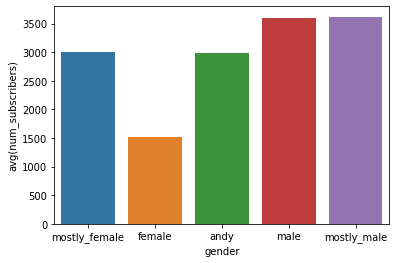

In [0]:
prev = datetime.datetime.now()
pltp = avg_num_subscribers_per_gender.toPandas()

sns.barplot(data = pltp, x ="gender", y = "avg(num_subscribers)")
print(datetime.datetime.now() - prev)

0:00:07.024565


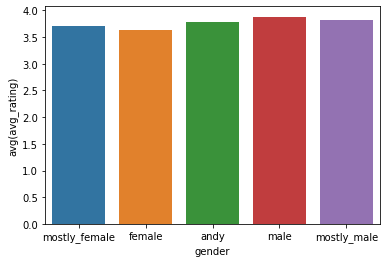

In [0]:
prev = datetime.datetime.now()
avg_avg_rating = known_instructors.groupBy('gender').agg(F.mean("avg_rating"))

sns.barplot(data = avg_avg_rating.toPandas(), x ="gender", y = "avg(avg_rating)")
print(datetime.datetime.now() - prev)